### Problem Definition
Merchants sometimes run big promotions (e.g., discounts or cash coupons) on particular dates (e.g., Boxing-day Sales, "Black Friday" or "Double 11 (Nov 11th)”, in order to attract a large number of new buyers. Unfortunately, many of the attracted buyers are one-time deal hunters, and these promotions may have little long lasting impact on sales. To alleviate this problem, it is important for merchants to identify who can be converted into repeated buyers. By targeting on these potential loyal customers, merchants can greatly reduce the promotion cost and enhance the return on investment (ROI). It is well known that in the field of online advertising, customer targeting is extremely challenging, especially for fresh buyers. However, with the long-term user behavior log accumulated by Tmall.com, we may be able to solve this problem.

We provide a set of merchants and their corresponding new buyers acquired during the promotion on the "Double 11" day. Your task is to predict which new buyers for given merchants will become loyal customers in the future. In other words, you need to predict the probability that these new buyers would purchase items from the same merchants again within 6 months.

## Data Description
The data set contains anonymized users' shopping logs in the past 6 months before and on the "Double 11" day,and the label information indicating whether they are repeated buyers. Due to privacy issue, data is sampled in a biased way, so the statistical result on this data set would deviate from the actual of Tmall.com. But it will not affect the applicability of the solution. The files for the training and testing data sets can be found in "data_format2.zip".Details of the data format can be found in the table below.


In [27]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, DMatrix
from xgboost import train
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

In [2]:
sample_sub=pd.read_csv('sample_submission.csv')

In [3]:
sample_sub.head()

,user_id,merchant_id,prob
0,163968,4605,0.5
1,360576,1581,0.5
2,98688,1964,0.5
3,98688,3645,0.5
4,295296,3361,0.5


In [19]:
DATA_DIR_1 = './data_format1/'
DATA_DIR_2 = './data_format2/'
TRAIN_PATH = DATA_DIR_1 + 'train_format1.csv'
TEST_PATH = DATA_DIR_1 + 'test_format1.csv'
USER_INFO_PATH = DATA_DIR_1 + 'user_info_format1.csv'
USER_LOG_PATH = DATA_DIR_1 + 'user_log_format1.csv'

In [20]:
df_train = pd.read_csv(TRAIN_PATH)
df_user_info = pd.read_csv(USER_INFO_PATH)
df_user_log = pd.read_csv(USER_LOG_PATH)
df_test = pd.read_csv(TEST_PATH)
df_test.drop('prob', axis=1, inplace=True)

df_train['kind'] = 'train'
df_test['kind'] = 'test'
df = df_train.append(df_test)

/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_79818/2099958949.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_test)


In [30]:
df_user_log_raw = pd.read_csv(USER_LOG_PATH)

In [31]:
df_user_log_raw.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


It is an enumerated type {0, 1, 2, 3}, where 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favourite.

In [32]:
df_user_log['time_stamp_raw'] = pd.to_datetime(df_user_log_raw['time_stamp'], format='%m%d')

In [38]:
df_user_log['month'] = df_user_log['time_stamp_raw'].dt.month
df_user_log['day'] = df_user_log['time_stamp_raw'].dt.day

In [39]:
df_user_log.drop(['time_stamp_raw'], axis=1, inplace=True)

In [28]:
df_user_log['user_id'] = df_user_log['user_id'].astype(np.int32)
df_user_log['item_id'] = df_user_log['item_id'].astype(np.int32)
df_user_log['cat_id'] = df_user_log['cat_id'].astype(np.int16)
df_user_log['seller_id'] = df_user_log['seller_id'].astype(np.int16)
df_user_log.rename(columns={'seller_id' : 'merchant_id'}, inplace=True)
df_user_log['brand_id'].fillna(0, inplace=True)
df_user_log['brand_id'] = df_user_log['brand_id'].astype(np.int16)
df_user_log['time_stamp'] = (pd.to_datetime(df_user_log['time_stamp'], format='%m%d') - pd.to_datetime(df_user_log['time_stamp'].min(), format='%m%d')).dt.days
df_user_log['time_stamp'] = df_user_log['time_stamp'].astype(np.int16)
df_user_log['action_type'] = df_user_log['action_type'].astype(np.int8)

In [40]:
df_user_log

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type,month,day
0,328862,323294,833,2882,2661,110,0,8,29
1,328862,844400,1271,2882,2661,110,0,8,29
2,328862,575153,1271,2882,2661,110,0,8,29
3,328862,996875,1271,2882,2661,110,0,8,29
4,328862,1086186,1271,1253,1049,110,0,8,29
...,...,...,...,...,...,...,...,...,...
54925325,208016,107662,898,1346,7995,183,0,11,10
54925326,208016,1058313,898,1346,7995,183,0,11,10
54925327,208016,449814,898,983,7995,183,0,11,10
54925328,208016,634856,898,1346,7995,183,0,11,10


In [41]:
df_user_info

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0
...,...,...,...
424165,395814,3.0,1.0
424166,245950,0.0,1.0
424167,208016,NaN,NaN
424168,272535,6.0,1.0


In [21]:
df_train

,user_id,merchant_id,label,kind
0,34176,3906,0,train
1,34176,121,0,train
2,34176,4356,1,train
3,34176,2217,0,train
4,230784,4818,0,train
...,...,...,...,...
260859,359807,4325,0,train
260860,294527,3971,0,train
260861,294527,152,0,train
260862,294527,2537,0,train


In [44]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from lightgbm import Dataset, LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

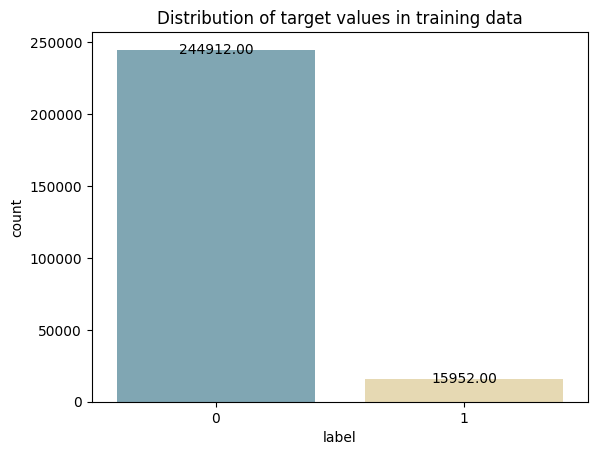

In [46]:
# Checking the data distribution of target variables

ax = sns.countplot(x = df_train['label'], palette='blend:#7AB,#EDA')
plt.title('Distribution of target values in training data')

# Iterating over the bars one-by-one
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                va='center', 
                ha='center')

In [22]:
df_test

,user_id,merchant_id,kind
0,163968,4605,test
1,360576,1581,test
2,98688,1964,test
3,98688,3645,test
4,295296,3361,test
...,...,...,...
261472,228479,3111,test
261473,97919,2341,test
261474,97919,3971,test
261475,32639,3536,test


In [6]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [8]:
user_log=pd.read_csv('./data_format1/user_log_format1.csv')

In [9]:
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [10]:
user_log.head() # 유저 로그

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [11]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   merchant_id  int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [12]:
train_data=pd.read_csv('./data_format1/train_format1.csv')

In [13]:
train_data.head() # training data

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


In [15]:
########## data format2

In [17]:
train2_data=pd.read_csv('./data_format2/train_format2.csv')

In [18]:
train2_data.head() # 로그가 분리되어 있지 않다 (format1은 분리되어 있음)

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [ ]:
### 데이터 전처리 해야 할 것들
# 1. 나이대 분류가 애매하다
# 2. user_info의 결측치 / 2(성별을 모르거나 NULL)인 값 처리
# ---> 제출형식에 성별은 없으므로, 성별을 모르는 경우에도 분석해도 될 듯
# 3. 결측치 얼마나 있는지 체크
# 4. timestamp 컬럼 사용할 시 형식 바꾸기
# 5. user_log의 seller_id -> merchant_id로 통일
# (이외에 더 전처리 할 것 없는지 찾기)

In [32]:
user_info[user_info['gender']==2] # 성별이 2인 것 개수: 10426

,user_id,age_range,gender
10,149002,5.0,2.0
42,116591,4.0,2.0
47,182794,6.0,2.0
55,97984,5.0,2.0
72,15868,5.0,2.0
...,...,...,...
423431,277998,3.0,2.0
423667,410416,0.0,2.0
423672,279024,3.0,2.0
423832,332019,NaN,2.0


In [31]:
user_info['gender'].isnull().sum() # 결측치 꽤 있음

6436